In [1]:
from Decoder import Decoder
from Encoder import Encoder
from VectorQuantizer import VectorQuantizer
from Residual import Residual 
from VQModel import VQModel

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
import math
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25
decay = 0.99
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
])

validation_data = datasets.ImageFolder(root="data/validation_images", transform=transform)

validation_loader = DataLoader(validation_data, batch_size=1,shuffle=True,pin_memory=True)

model = VQModel(num_hiddens, num_residual_layers, num_residual_hiddens,
                  num_embeddings, embedding_dim,
                  commitment_cost, decay).to(device)
model.load_state_dict(torch.load("Models/Model_2000", weights_only=True))
model.eval();

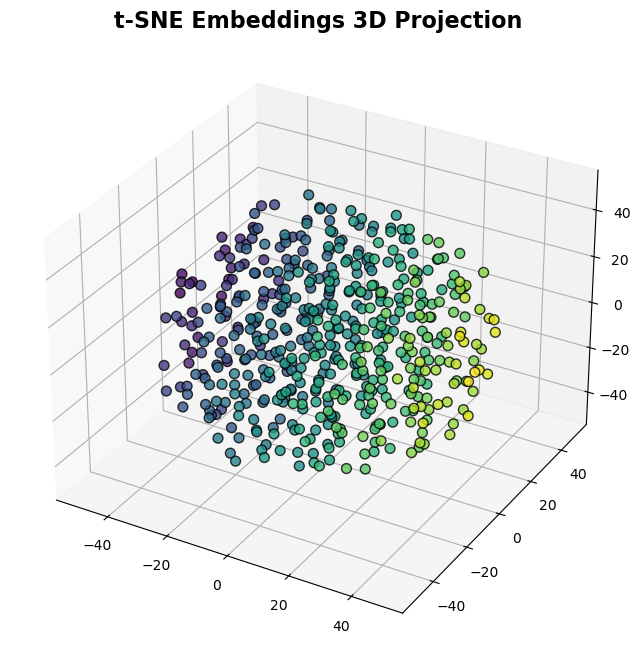

In [3]:
# Initialize the t-SNE model for 3D
tsne_model = TSNE(n_components=3, perplexity=30, metric='cosine', random_state=42)

# Perform the transformation
embedding_data = model._vq_vae._embedding.weight.data.cpu().numpy()
proj = tsne_model.fit_transform(embedding_data)

# Create a colormap based on a property of the data (e.g., first dimension)
colors = proj[:, 0]
norm_colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    proj[:, 0], proj[:, 1], proj[:, 2],
    c=norm_colors,  
    cmap='viridis',  
    s=50,  # Point size
    alpha=0.8,  # Slight transparency for depth perception
    edgecolors='k'  # Black edge for better contrast
)
# Add labels and title
ax.set_title("t-SNE Embeddings 3D Projection", fontsize=16, weight='bold')
# Add interactive rotation
plt.show()

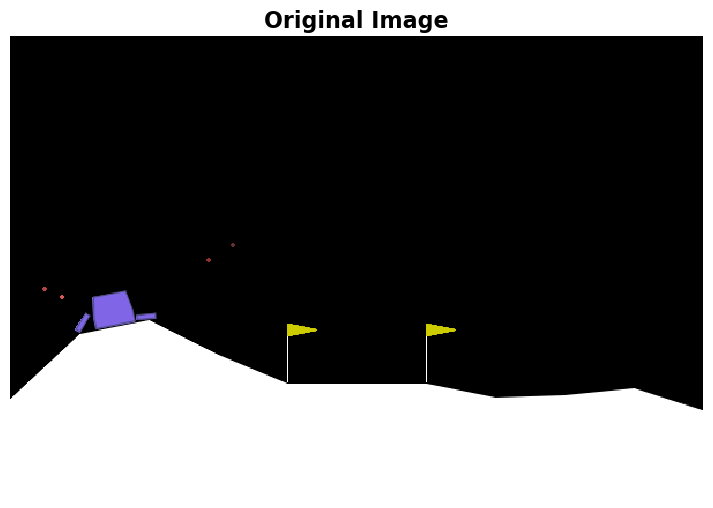

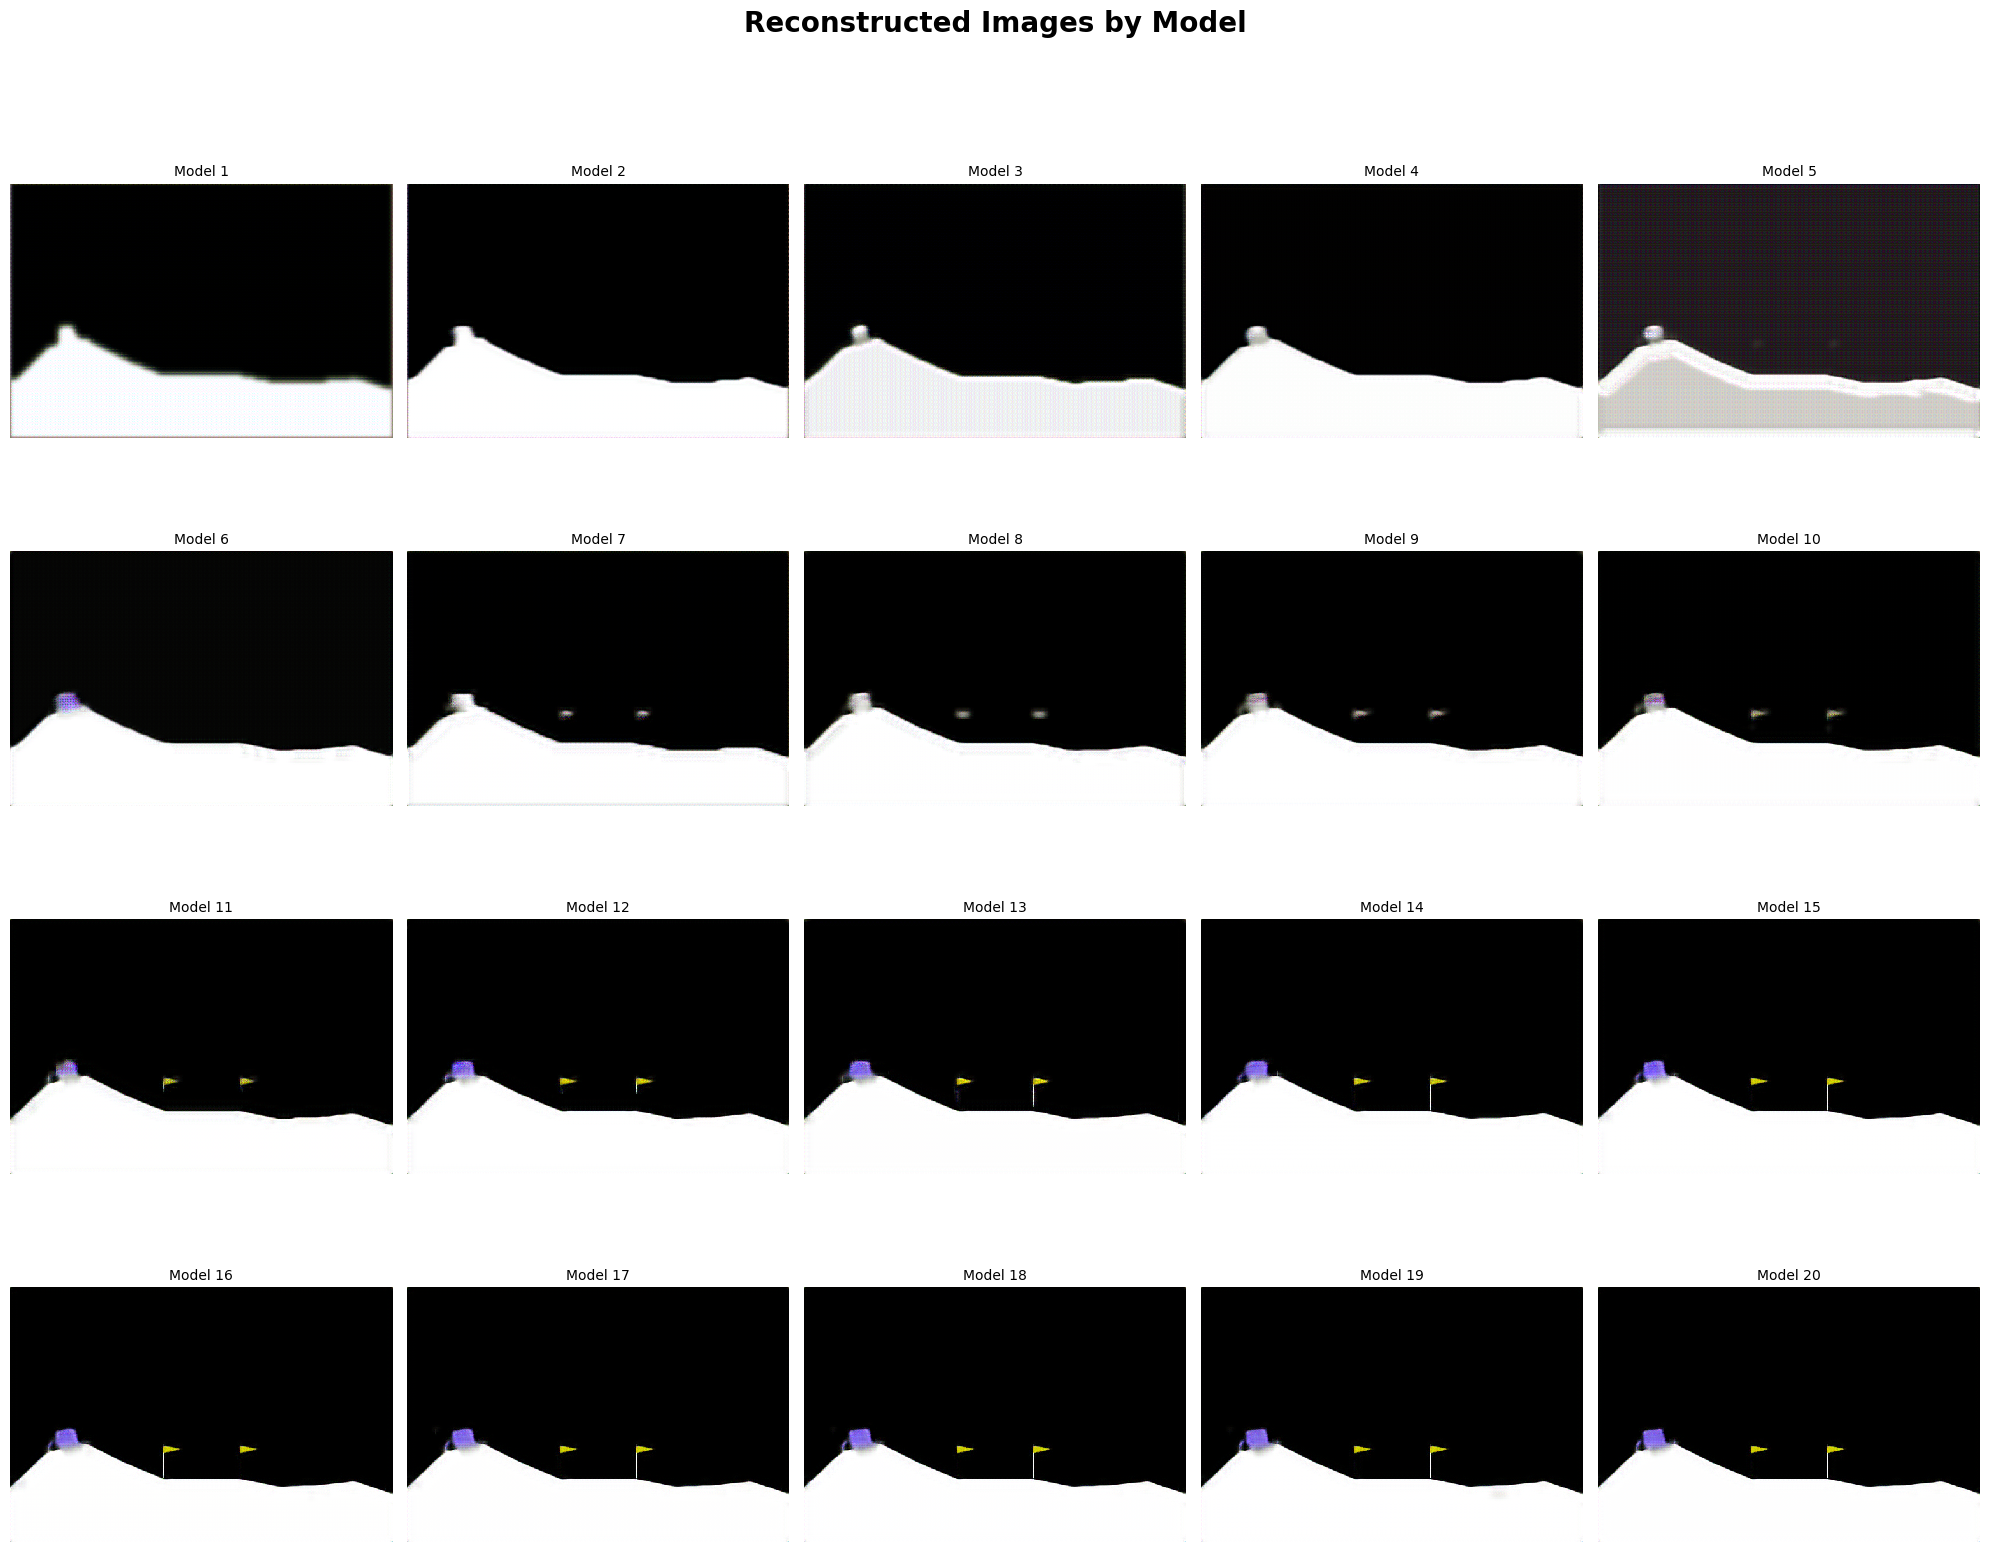

In [6]:
# Prepare validation data
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

# Plot original images
def plot_original_images(images, title="Original Image"):
    plt.figure(figsize=(12, 6))
    original_img = make_grid(images.cpu().data, nrow=7, padding=2) + 0.5
    original_npimg = np.clip(original_img.numpy(), 0, 1)  # Ensure values are within valid range
    plt.imshow(np.transpose(original_npimg, (1, 2, 0)), interpolation='nearest')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.show()

plot_original_images(valid_originals, title="Original Image")

# Load and visualize reconstructed images
def plot_reconstructed_images(models_directory, valid_originals, num_hiddens, num_residual_layers,
                              num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost,
                              decay, device):
    # Fetch model paths
    model_paths = [os.path.join(models_directory, f) for f in os.listdir(models_directory)
                   if os.path.isfile(os.path.join(models_directory, f))]
    n_models = len(model_paths)
    images_per_row = 5
    rows = math.ceil(n_models / images_per_row)

    # Set up the figure
    fig, axs = plt.subplots(rows, images_per_row, figsize=(20, rows * 4))
    axs = axs.flatten()  # Flatten to iterate easily

    # Loop through models and plot reconstructions
    for i, model_path in enumerate(model_paths):
        # Load and evaluate the model
        model = VQModel(num_hiddens, num_residual_layers, num_residual_hiddens,
                        num_embeddings, embedding_dim, commitment_cost, decay).to(device)
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()

        # Generate reconstructions
        vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
        _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
        valid_reconstructions = model._decoder(valid_quantize)

        # Prepare and plot reconstructions
        recon_img = make_grid(valid_reconstructions.cpu().data, nrow=7, padding=2) + 0.5
        recon_npimg = np.clip(recon_img.numpy(), 0, 1)
        axs[i].imshow(np.transpose(recon_npimg, (1, 2, 0)), interpolation='nearest')
        axs[i].set_title(f"Model {i + 1}", fontsize=10)
        axs[i].axis('off')

    # Hide unused subplots if necessary
    for j in range(n_models, len(axs)):
        axs[j].axis('off')

    # Adjust layout
    fig.suptitle("Reconstructed Images by Model", fontsize=20, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

models_directory = "Models" 

plot_reconstructed_images(
    models_directory=models_directory,
    valid_originals=valid_originals,
    num_hiddens=num_hiddens,
    num_residual_layers=num_residual_layers,
    num_residual_hiddens=num_residual_hiddens,
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
    commitment_cost=commitment_cost,
    decay=decay,
    device=device
)